### Imports  & Parameters

In [13]:
%load_ext autoreload
%autoreload 2

import os, sys
# ugly workaround for imports
sys.path.append(os.path.split(os.getcwd())[0])

import numpy as np
import scipy as sp
import matplotlib
matplotlib.rcParams['animation.html'] = 'html5'

import matplotlib.pyplot as pl
import matplotlib.animation as animation
%matplotlib inline

from fit import *
from utils.prf import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# parameters of analysis
n_pix = 30
rsq_threshold = 0.35

In [15]:
# settings that have to do with the data and experiment
nr_prf_parameters = 8
TR = 0.945
screen_distance = 225
screen_width = 39
nr_TRs = 462
timepoints = np.arange(nr_TRs) * TR
extent = [-5, 5]
stim_radius = 9.0
n_folds = 6

### Get Data

`prf_cv_fold_data` is the prf parameters, 
`rfs` are the pixel-based rf profiles.

data file found, returning local file ../data/V1.h5


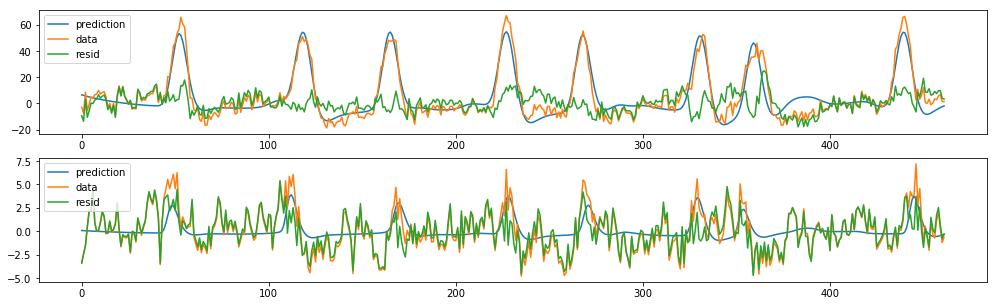

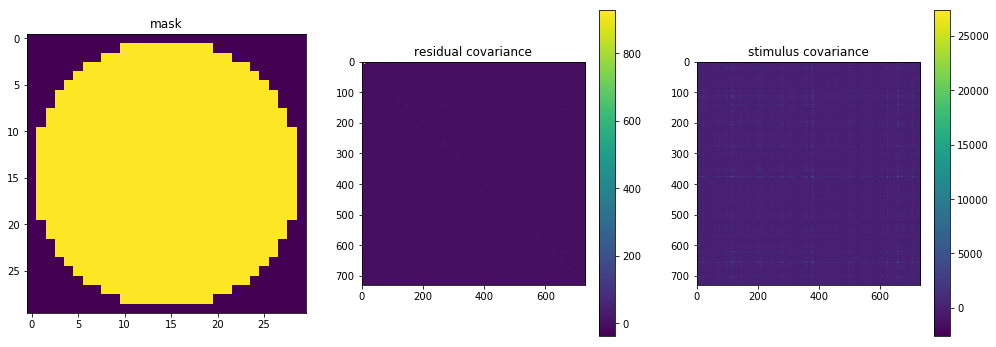

In [16]:
(prf_cv_fold_data, rfs, linear_predictor, 
 all_residuals_css, all_residual_covariance_css, 
 stimulus_covariance_WW, test_data, mask) = setup_data_from_h5(
                        data_file = '../data/V1.h5', 
                        n_pix=n_pix, 
                        extent=extent, 
                        stim_radius=stim_radius, 
                        screen_distance=screen_distance, 
                        screen_width=screen_width, 
                        rsq_threshold=rsq_threshold,
                        TR=TR,
                        cv_fold=1,
                        n_folds=n_folds,
                        use_median=True)

f = pl.figure(figsize=(17,6))
s = f.add_subplot(131)
pl.imshow(mask);
s.set_title('mask')
s = f.add_subplot(132)
pl.imshow(all_residual_covariance_css)
s.set_title('residual covariance')
pl.colorbar()
s = f.add_subplot(133)
pl.imshow(stimulus_covariance_WW)
s.set_title('stimulus covariance')
pl.colorbar();

max tau: 29.4826668903 min tau: -12.0544877701
sigma: -0.035052245444 rho: 0.0402457832294
summed squared distance: 1283549.87346


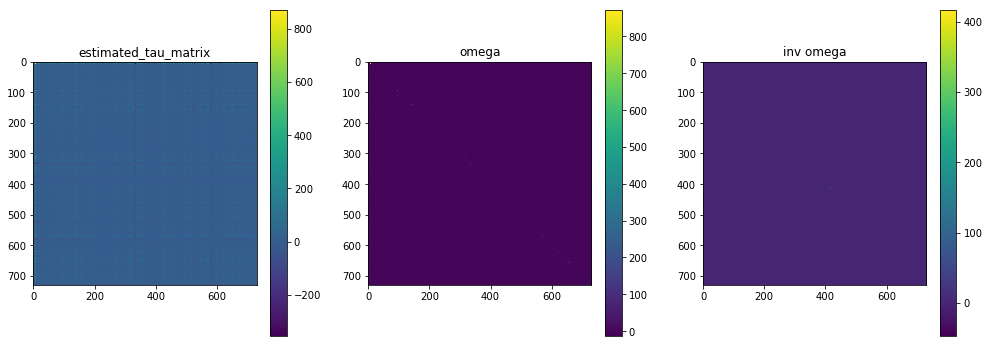

In [17]:
# estimate the covariance structure, which outputs all parameters
(estimated_tau_matrix, estimated_rho, 
 estimated_sigma, omega, 
 omega_inv, logdet) = fit_model_omega(
                                        observed_residual_covariance=all_residual_covariance_css, 
                                        featurespace_covariance=stimulus_covariance_WW,
                                        verbose=1
                                        )

f = pl.figure(figsize=(17,6))
s = f.add_subplot(131)
pl.imshow(estimated_tau_matrix)
s.set_title('estimated_tau_matrix')
pl.colorbar()
s = f.add_subplot(132)
pl.imshow(omega)
s.set_title('omega')
pl.colorbar()
s = f.add_subplot(133)
pl.imshow(omega_inv)
s.set_title('inv omega')
pl.colorbar();

In [18]:
# set up result array:
dm_pixel_logl_ratio = np.zeros((mask.sum(),test_data.shape[1]))

# and loop across timepoints
for t, bold in enumerate(test_data.T):
    dm_pixel_logl_ratio[:,t] = firstpass_decoder_independent_Ws(
                                        bold=bold, 
                                        logdet=logdet,
                                        omega_inv=omega_inv,
                                        linear_predictor=linear_predictor)

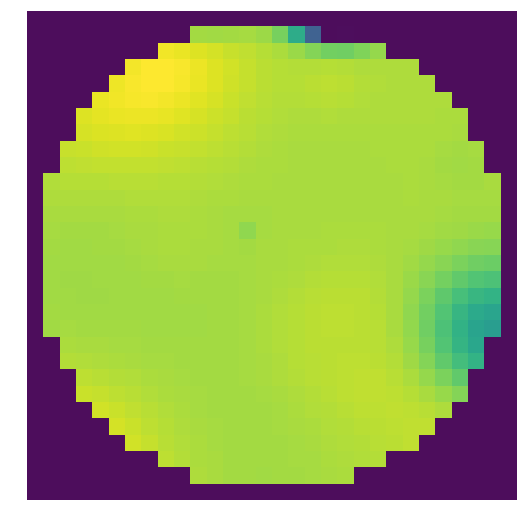

In [20]:
from IPython.display import HTML

fig = pl.figure(figsize=(9, 9))
ims = []

for t in range(dm_pixel_logl_ratio.shape[1]):
    stim_2d_array = np.zeros(mask.shape)
    stim_2d_array[mask] = dm_pixel_logl_ratio[:,t]


    #the video animation is currently not working for me. not sure how to fix it
    # fig.gca().add_patch(pl.Circle((int(n_pix/2), int(n_pix/2)), radius=8, facecolor='w',
    #                             edgecolor='k', fill=False, linewidth=3.0))
    extentz=[int(n_pix/2)-stim_radius,int(n_pix/2)+stim_radius,int(n_pix/2)-stim_radius,int(n_pix/2)+stim_radius,]
    # im = pl.imshow(dm_pixel_logl_ratio[:,:,t], animated=True, clim=[dm_pixel_logl_ratio.min(
    # ), dm_pixel_logl_ratio.max()], cmap='viridis', alpha=0.95)#, extent=extentz)    
    im = pl.imshow(stim_2d_array, animated=True, clim=[dm_pixel_logl_ratio.min(
    ), dm_pixel_logl_ratio.max()], cmap='viridis', alpha=0.95)#, extent=extentz)
    pl.axis('off')
    ims.append([im])

ani = animation.ArtistAnimation(
    fig, ims, interval=150, blit=True, repeat_delay=1500)

ani

# HTML(ani.to_html5_video())
# ani.save('out.avi')

In [8]:
# decoded_image = np.zeros((mask.sum(),test_data.shape[1]))  
# for t, bold in enumerate(test_data.T):
#     decoded_image[:,t] = maximize_loglikelihood(
#                                         starting_value=dm_pixel_logl_ratio[:,t],
#                                         bold=bold,
#                                         logdet=logdet,
#                                         omega_inv=omega_inv,
#                                         rfs=rfs, 
#                                         prf_data=prf_cv_fold_data)
    

In [22]:
decoded_image = np.zeros((mask.sum(),test_data.shape[1]))  
for t, bold in enumerate(test_data.T):
    
    starting_value=dm_pixel_logl_ratio[:,t]
    prf_data=prf_cv_fold_data
    bnds=[(-10,10) for elem in rfs]


    final_result=sp.optimize.minimize(
                                    calculate_bold_loglikelihood, 
                                    starting_value, 
                                    args=(  rfs,
                                            prf_data, 
                                            logdet, 
                                            omega_inv, 
                                            bold), 
                                    method='L-BFGS-B', 
                                    bounds=bnds,
                                    tol=1e-03,
                                    options={'disp':False})
    decoded_image[:,t] = final_result.x
    logl = -final_result.fun
    print(t)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

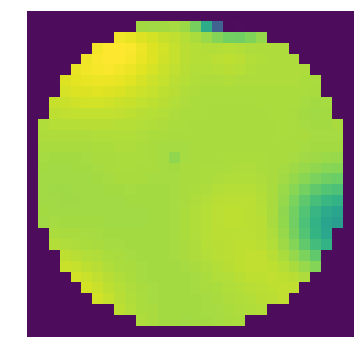

In [23]:
fig = pl.figure(figsize=(6, 6))
ims = []

for t in range(decoded_image.shape[1]):
    stim_2d_array = np.zeros(mask.shape)
    stim_2d_array[mask] = decoded_image[:,t]

    #the video animation is currently not working for me. not sure how to fix it
    # fig.gca().add_patch(pl.Circle((int(n_pix/2), int(n_pix/2)), radius=8, facecolor='w',
    #                             edgecolor='k', fill=False, linewidth=3.0))
    extentz=[int(n_pix/2)-stim_radius,int(n_pix/2)+stim_radius,int(n_pix/2)-stim_radius,int(n_pix/2)+stim_radius,]
    # im = pl.imshow(dm_pixel_logl_ratio[:,:,t], animated=True, clim=[dm_pixel_logl_ratio.min(
    # ), dm_pixel_logl_ratio.max()], cmap='viridis', alpha=0.95)#, extent=extentz)    
    im = pl.imshow(stim_2d_array, animated=True, clim=[decoded_image.min(
    ), decoded_image.max()], cmap='viridis', alpha=0.95)#, extent=extentz)
    pl.axis('off')
    ims.append([im])

ani = animation.ArtistAnimation(
    fig, ims, interval=150, blit=True, repeat_delay=1500)

ani